# More about decision trees

* Example cases where non-linear effects are really apparent
  * Classification
  * Regression
* What kind of decision boundary does a tree learn?
* Regularization methods
* Random Forests

## Dataset creation
Download the `reading_levels.csv` file and the `Urban land cover.zip` from Canvas. Unzip the data in the same directory as this notebook. 

In the `reading_levels.csv` dataset, `reading_grade_level` is a regression target and `first_choice_college` is a classification target.

In [2]:
import pandas as pd

df = pd.read_csv('reading_levels.csv')
df

,age_months,reading_grade_level,first_choice_college
0,157,13.774510,False
1,8,0.000000,False
2,0,0.000000,False
3,95,3.486615,False
4,38,0.224636,False
...,...,...,...
982,238,18.249983,True
983,177,14.639292,False
984,101,4.371040,False
985,126,10.486085,True


## Classification with obvious non-linear effects

Classify whether the student was accepted into their first choice of college based on age and reading grade level

In [3]:
# Classification
from sklearn import tree, model_selection, metrics

features = ['age_months', 'reading_grade_level']
X = df[features]
y = df.first_choice_college

model = tree.DecisionTreeClassifier(min_samples_leaf=20)
xval = model_selection.KFold(10, shuffle=True)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(model,
    X, y, cv=xval, scoring=scorer,
    return_train_score=True)

print('Kappa mean:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())
print('Train kappa mean:', result['train_score'].mean())

Kappa mean: 0.6619662074167063
Kappa SD: 0.08261571207744395
Train kappa mean: 0.757031078694543


### Visualize Data

Text(0, 0.5, 'Reading grade level')

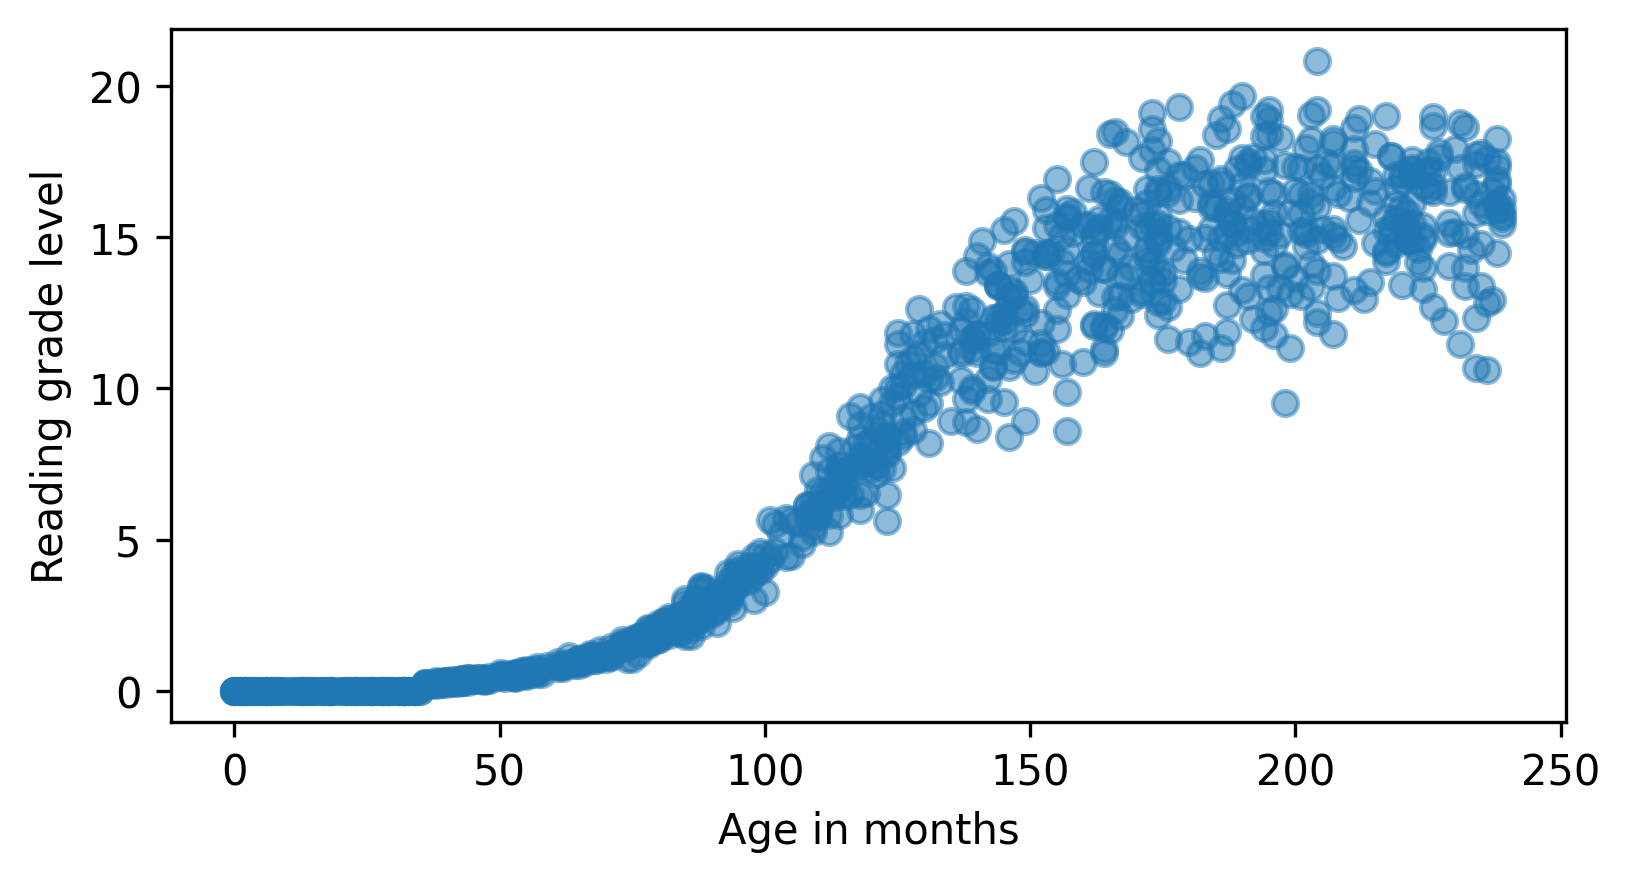

In [4]:
import matplotlib.pyplot as plt

# visualize data
plt.figure(dpi=300, figsize=(6, 3))
plt.scatter(X.age_months, X.reading_grade_level, alpha=0.5)
plt.xlabel('Age in months')
plt.ylabel('Reading grade level')

### Visualize Data with Labels

Text(0, 0.5, 'Reading grade level')

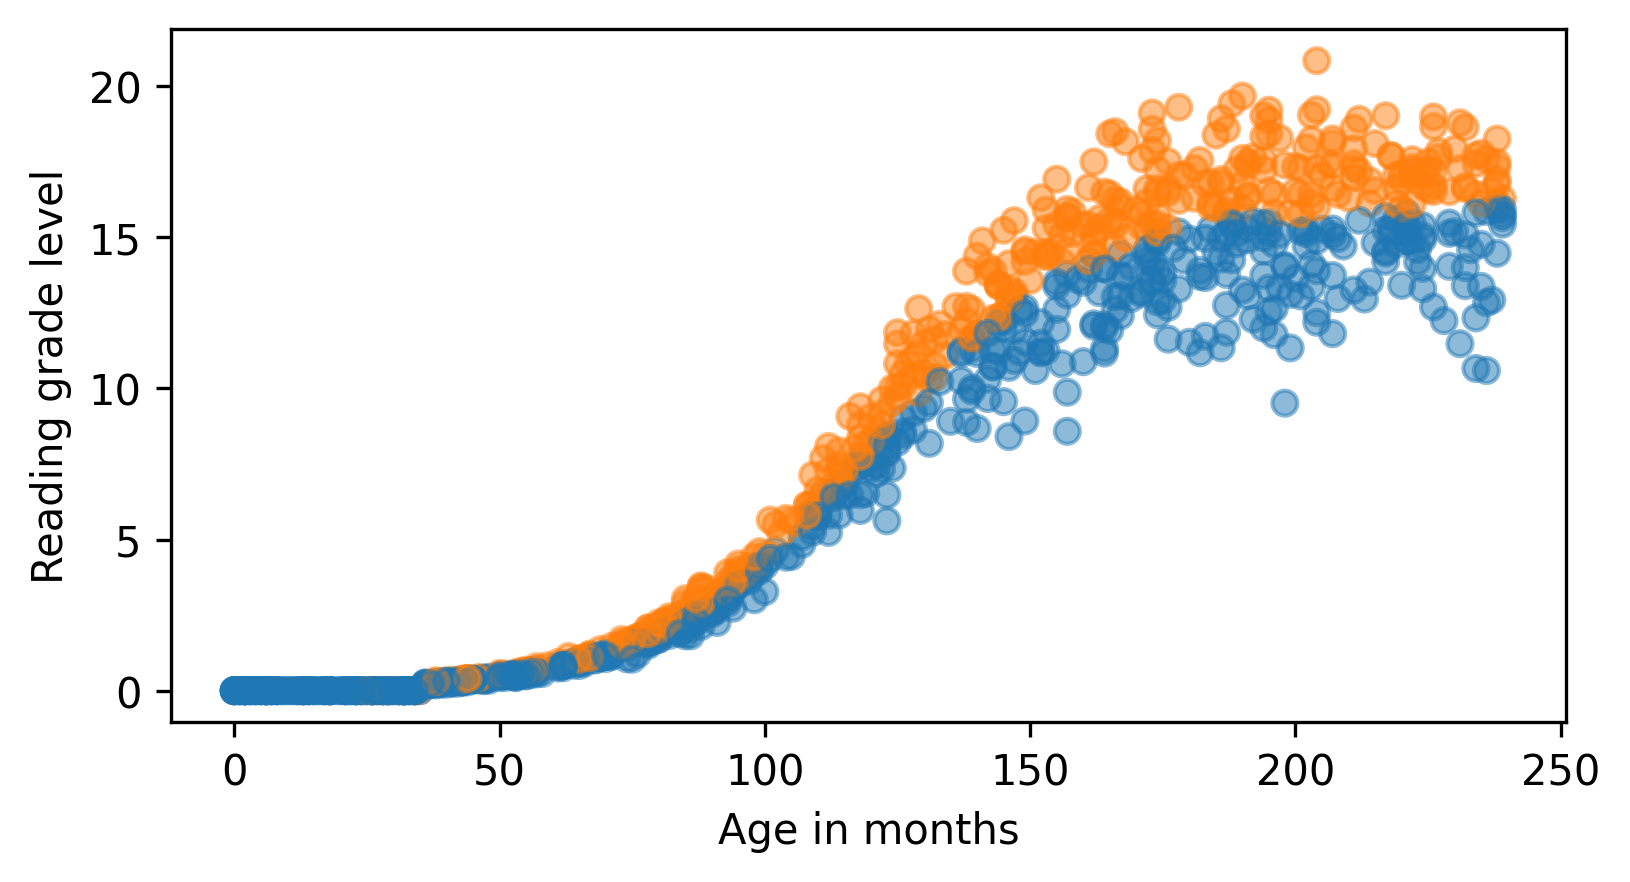

In [5]:
# Visualize labels
plt.figure(dpi=300, figsize=(6, 3))
colors = []
for fcc in df.first_choice_college:
    if fcc == 1:
        colors.append('C1')
    else:
        colors.append('C0')
plt.scatter(X.age_months, X.reading_grade_level, alpha=.5, c=colors)
plt.xlabel('Age in months')
plt.ylabel('Reading grade level')

### Visualize Predictions

Text(0, 0.5, 'Reading grade level')

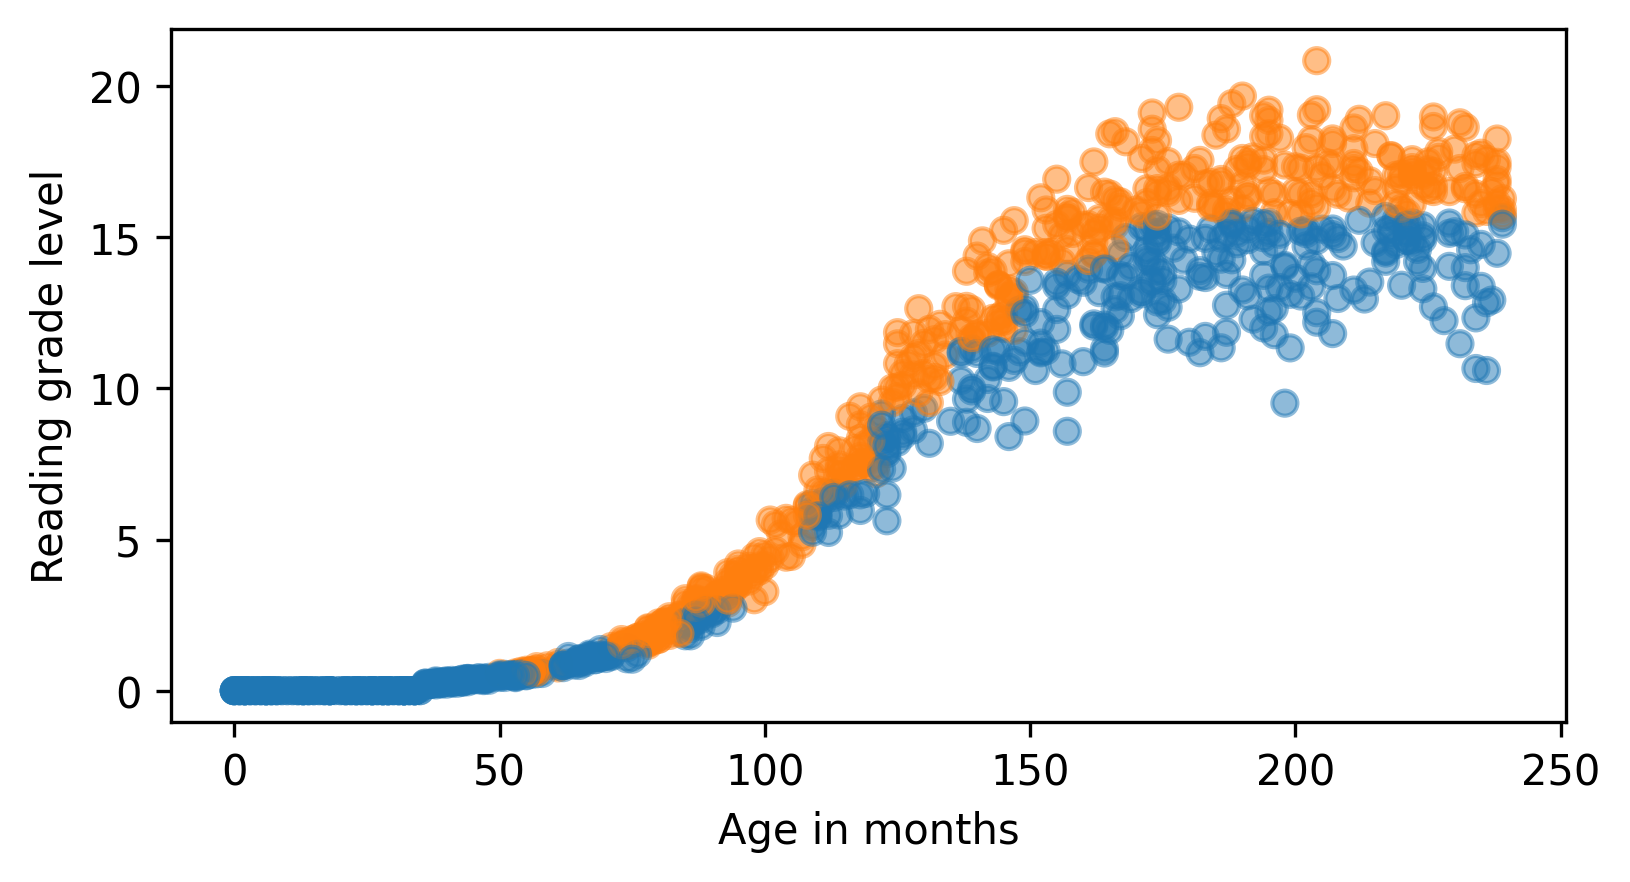

In [6]:
# train model on all data for visualization purposes
model.fit(X, y)
predictions = model.predict(X)

plt.figure(dpi=300, figsize=(6, 3))
colors = []
for p in predictions:
    if p == 0:
        colors.append('C0')
    else:
        colors.append('C1')
plt.scatter(X.age_months, X.reading_grade_level, alpha=.5, c=colors)
plt.xlabel('Age in months')
plt.ylabel('Reading grade level')

## Regression with obvious non-linear effects

Instead of predicting college admissions, what if we wanted to explore the relationship between age and reading level by predicting reading level? Would a Decision Tree or a Linear Regression model perform better?

In [7]:
features = ['age_months']
X = df[features]
y = df.reading_grade_level
model = tree.DecisionTreeRegressor(min_samples_leaf=20)
#from sklearn import linear_model
#model = linear_model.LinearRegression()
xval = model_selection.KFold(10, shuffle=True)
result = model_selection.cross_validate(model,
    X, y, cv=xval, scoring='r2',
    return_train_score=True)

print('R^2 mean:', result['test_score'].mean())
print('R^2 SD:', result['test_score'].std())
print('Train R^2 mean:', result['train_score'].mean())

R^2 mean: 0.9573120497090988
R^2 SD: 0.007085236393022901
Train R^2 mean: 0.9636105913349129


### Visualize tree regression curve

In [8]:
# First train model on everything
model = tree.DecisionTreeRegressor(min_samples_leaf=100)
model.fit(X, y)

# Make predictions on each age range in the dataset (0 to maximum value of age_months)
x_vals = []
for val in range(0, df.age_months.max() + 1):
    x_vals.append(val)
vis_X = pd.DataFrame({'age_months': x_vals})
vis_X

predictions = model.predict(vis_X)
predictions

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.10716535,  0.10716535,  0.10716535,  0.10716535,  0.10716535,
        0.10716535,  0.10716535,  0.10716535,  0.10716535,  0.10716535,
        0.10716535,  0.10716535,  0.10716535,  0.10716535,  0.10716535,
        0.10716535,  0.10716535,  0.10716535,  0.10716535,  0.69171071,
        0.69171071,  0.69171071,  0.69171071,  0.69171071,  0.69171071,
        0.69171071,  0.69171071,  0.69171071,  0.69171071,  0.69171071,
        0.69171071,  0.69171071,  0.69171071,  0.69171071,  0.69171071,
        0.69171071,  0.69171071,  0.69171071,  0.69171071,  0.69171071,
        0.69171071,  0.69171071,  0.69171071,  0.69171071,  0.69

Text(0, 0.5, 'Reading grade level')

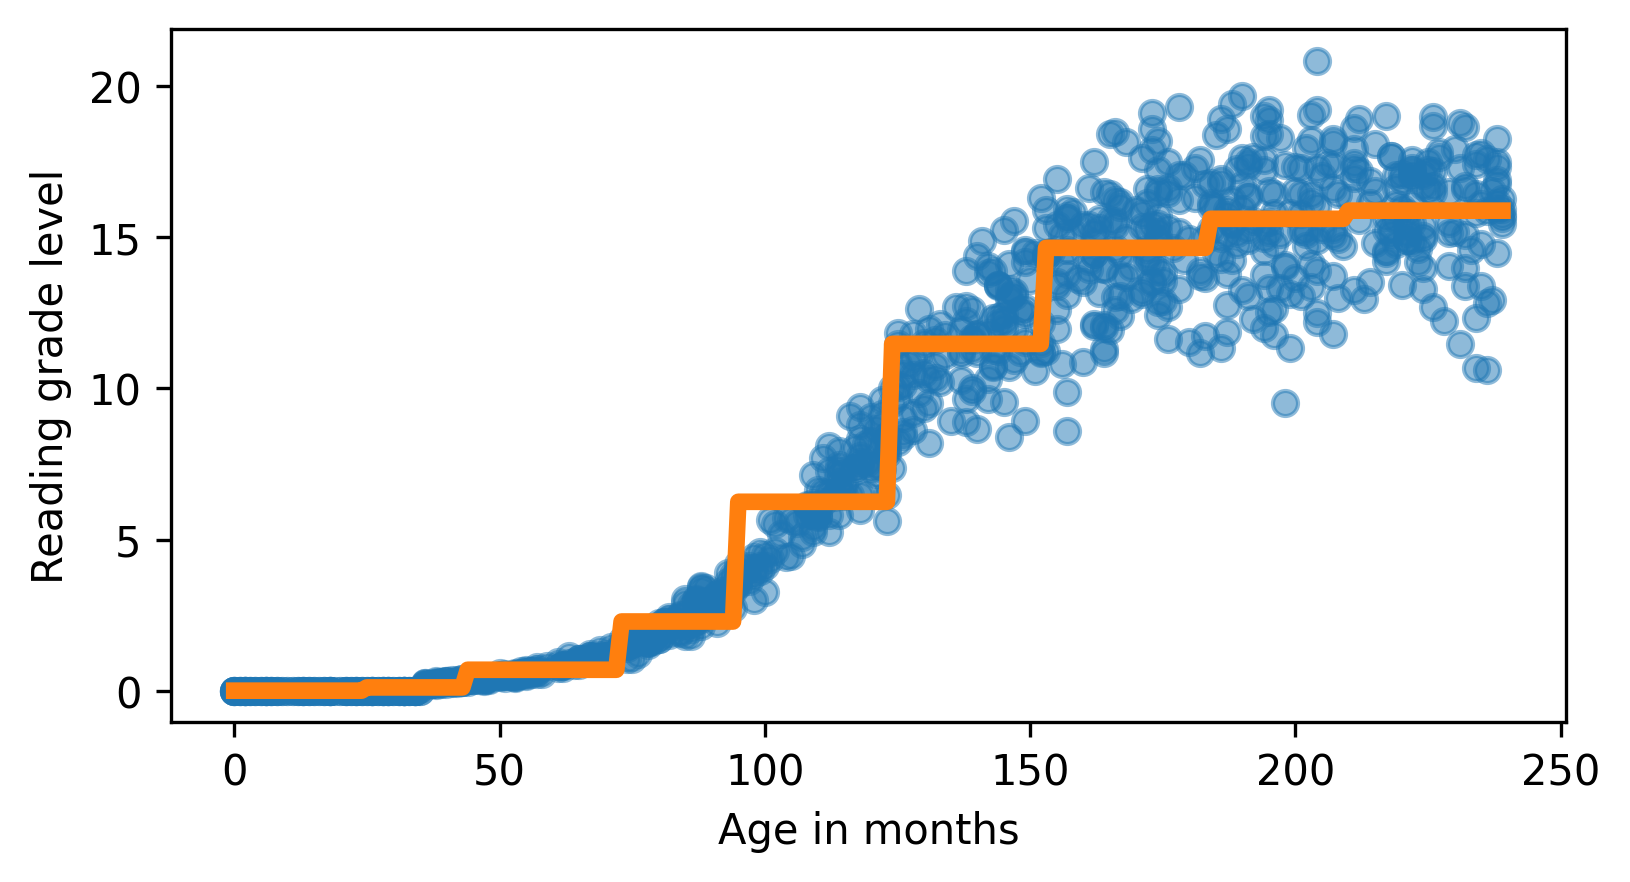

In [9]:
plt.figure(dpi=300, figsize=(6, 3))
plt.scatter(df.age_months, df.reading_grade_level, alpha=.5)
plt.plot(vis_X.age_months, predictions, c='C1', linewidth=4)
plt.xlabel('Age in months')
plt.ylabel('Reading grade level')

# Observe that DT's regression line can only be perpendicular or parallel to features. 
# This results in step-like patterns because decision trees create axis-aligned splits.
# Even for simple relationships, the model has difficulty making diagonal lines. This is a very inefficient use of data!
# This shows that DTs can have limitations when handling continuous data with non-axis-aligned relationships, 
# as they don't generalize smooth trends easily.

## Regularization nuances

* Shallow all over vs. shallow in places
* Number of instances in leaves using `max_depth`
* Example decision boundaries for highly vs. loosely regularized models
* Example datasets where regularization is really needed vs. less so

In [10]:
print(X)
print(y)  # Remember what we're predicting

     age_months
0           157
1             8
2             0
3            95
4            38
..          ...
982         238
983         177
984         101
985         126
986         201

[987 rows x 1 columns]
0      13.774510
1       0.000000
2       0.000000
3       3.486615
4       0.224636
         ...    
982    18.249983
983    14.639292
984     4.371040
985    10.486085
986    16.430489
Name: reading_grade_level, Length: 987, dtype: float64


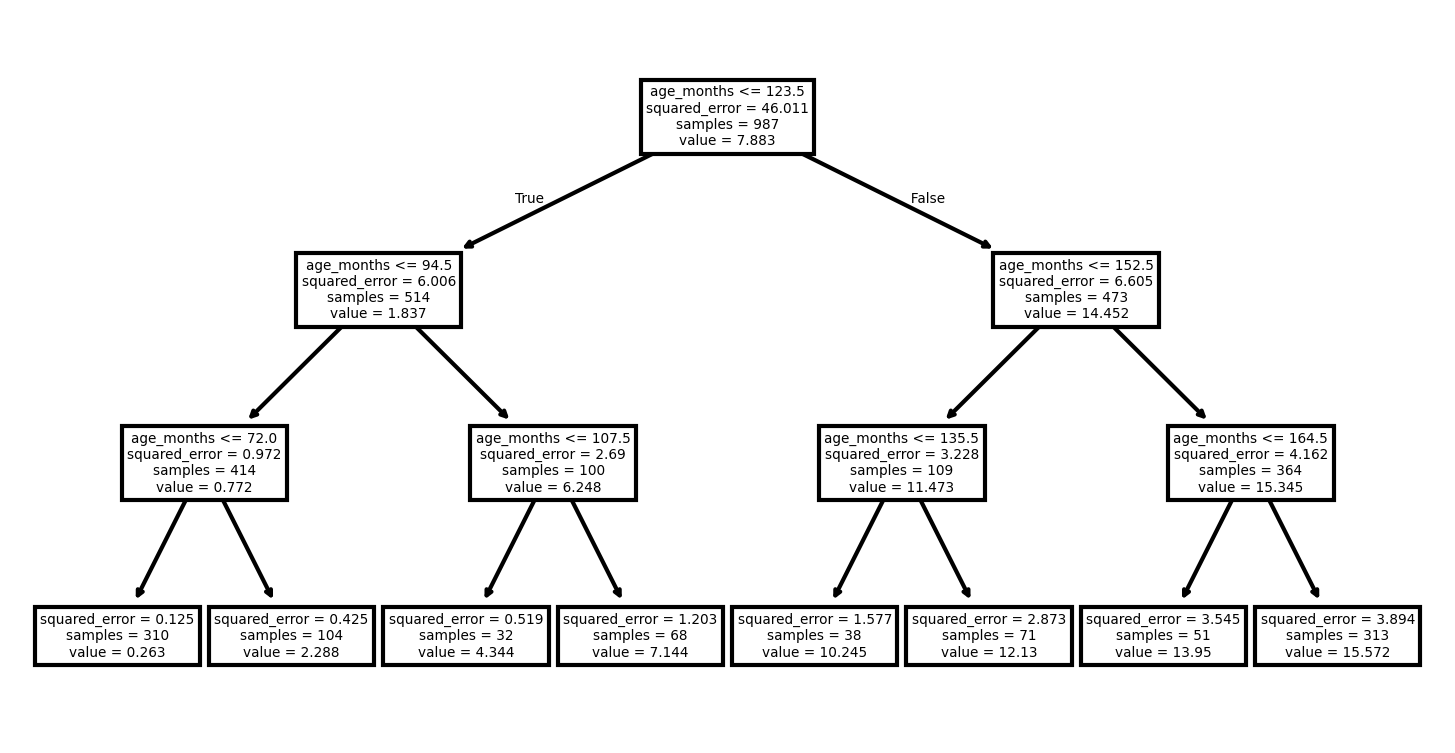

In [11]:
model = tree.DecisionTreeRegressor(max_depth=3) #prune by max depth this time, try other regularization methods e.g., min_samples_leaf
model.fit(X, y)

plt.figure(dpi=300, figsize=(6, 3))
_ = tree.plot_tree(model, feature_names=features)

## Random Forest Classifier (Semi-Manual Version)

In [12]:
# Manually create two different trees on subsets of data and average them together
model1 = tree.DecisionTreeClassifier(min_samples_leaf=25)
model2 = tree.DecisionTreeClassifier(min_samples_leaf=25)
model3 = tree.DecisionTreeClassifier(min_samples_leaf=25)

features = ['age_months', 'reading_grade_level']
train_df = df.iloc[:700]
test_df = df.iloc[700:]

# Sample subsets of data with replacement
df1 = train_df.sample(frac=.75, replace=True)
df1.index.nunique()
df2 = train_df.sample(frac=.75, replace=True)
df2.index.nunique()
df3 = train_df.sample(frac=.75, replace=True)

# We only have two features so we will not sample subsets of features :(
model1.fit(df1[features], df1.first_choice_college)
model2.fit(df2[features], df2.first_choice_college)
model3.fit(df3[features], df3.first_choice_college)

pred1 = model1.predict(test_df[features])
pred2 = model2.predict(test_df[features])
pred3 = model3.predict(test_df[features])
print('Model 1 vs. 2 correlation:', pd.Series(pred1).corr(pd.Series(pred2)))
print('Model 2 vs. 3 correlation:', pd.Series(pred2).corr(pd.Series(pred3)))

Model 1 vs. 2 correlation: 0.6386241842378331
Model 2 vs. 3 correlation: 0.49579837342034017


In [13]:
# Now examine kappa of model 1, 2, 3, and avg
acc1 = metrics.cohen_kappa_score(test_df.first_choice_college, pred1)
acc2 = metrics.cohen_kappa_score(test_df.first_choice_college, pred2)
acc3 = metrics.cohen_kappa_score(test_df.first_choice_college, pred3)
print('Model 1 kappa:', acc1)
print('Model 2 kappa:', acc2)
print('Model 3 kappa:', acc3)

Model 1 kappa: 0.6294711794040959
Model 2 kappa: 0.5738088646145327
Model 3 kappa: 0.5531219183059117


In [14]:
print(pred1[0:10])
print(pred2[0:10])
print(pred3[0:10])

print((pred1*1)[0:10])

[False False False  True  True False False False  True  True]
[False False False  True  True  True False False  True  True]
[False False False  True False False False  True False  True]
[0 0 0 1 1 0 0 0 1 1]


In [15]:
# Average together
avg_pred = (pred1*1 + pred2*1 + pred3*1) / 3
print(avg_pred[0:10])
avg_pred = avg_pred > .5
avg_pred*1

[0.         0.         0.         1.         0.66666667 0.33333333
 0.         0.33333333 0.66666667 1.        ]


array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1])

In [16]:
avg_acc = metrics.cohen_kappa_score(test_df.first_choice_college, avg_pred)
print('Average model kappa:', avg_acc)
mean_acc = (acc1 + acc2 + acc3) / 3
print('Mean of model kappas:', mean_acc)

Average model kappa: 0.6273201782304265
Mean of model kappas: 0.5854673207748468


Observe that the average kappa is higher than one of the models.

### Random Forest in `scikit-learn`

In [17]:
from sklearn import ensemble

# Takes same hyperparameters as trees
# (plus some for the random splitting stuff)
model = ensemble.RandomForestClassifier(100, min_samples_leaf=25)

X = df[features]
y = df.first_choice_college

xval = model_selection.KFold(10, shuffle=True)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(model,
    X, y, cv=xval, scoring=scorer,
    return_train_score=True)

print('Kappa mean:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())
print('Train kappa mean:', result['train_score'].mean())

Kappa mean: 0.6158703810120565
Kappa SD: 0.07153043792497518
Train kappa mean: 0.7239561505460419


Also works for regression!

In [19]:
df1 = pd.read_csv('Urban land cover/training.csv')
df2 = pd.read_csv('Urban land cover/testing.csv')
combined_df = pd.concat([df1, df2])
features = ['Area', 'Round', 'Bright', 'Compact']

In [20]:
# Observe min_samples_leaf=5 is often a little better (less overfitting than min_samples_leaf=1)
model = tree.DecisionTreeClassifier(min_samples_leaf=1)
xval = model_selection.KFold(5)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(model,
    combined_df[features], combined_df['class'],
    cv=xval, scoring=scorer, return_train_score=True)
print('Kappa mean:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())
print('Train kappa mean:', result['train_score'].mean())

Kappa mean: 0.47504751950701946
Kappa SD: 0.03661781620179994
Train kappa mean: 1.0


In [21]:
# Observe here that RF doesn't help much
model = ensemble.RandomForestClassifier(min_samples_leaf=1)
xval = model_selection.KFold(5)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(model,
    combined_df[features], combined_df['class'],
    cv=xval, scoring=scorer, return_train_score=True)
print('Kappa mean:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())
print('Train kappa mean:', result['train_score'].mean())

Kappa mean: 0.5585075081936997
Kappa SD: 0.030639999535204833
Train kappa mean: 1.0


Let's also explore KNN on this dataset with all features.

In [22]:
from sklearn import neighbors

features = [f for f in combined_df.columns if f != 'class']

# Just doesn't work well even with k=2...5
model = neighbors.KNeighborsClassifier(1)
xval = model_selection.KFold(5)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(model,
    combined_df[features], combined_df['class'],
    cv=xval, scoring=scorer, return_train_score=True)
print('Kappa mean:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())
print('Train kappa mean:', result['train_score'].mean())

Kappa mean: 0.2970743656615242
Kappa SD: 0.06042855001445047
Train kappa mean: 1.0


Also overfits a lot. 
Too many features (dimensions)!

In [23]:
len(features)

147

In [24]:
features

['BrdIndx',
 'Area',
 'Round',
 'Bright',
 'Compact',
 'ShpIndx',
 'Mean_G',
 'Mean_R',
 'Mean_NIR',
 'SD_G',
 'SD_R',
 'SD_NIR',
 'LW',
 'GLCM1',
 'Rect',
 'GLCM2',
 'Dens',
 'Assym',
 'NDVI',
 'BordLngth',
 'GLCM3',
 'BrdIndx_40',
 'Area_40',
 'Round_40',
 'Bright_40',
 'Compact_40',
 'ShpIndx_40',
 'Mean_G_40',
 'Mean_R_40',
 'Mean_NIR_40',
 'SD_G_40',
 'SD_R_40',
 'SD_NIR_40',
 'LW_40',
 'GLCM1_40',
 'Rect_40',
 'GLCM2_40',
 'Dens_40',
 'Assym_40',
 'NDVI_40',
 'BordLngth_40',
 'GLCM3_40',
 'BrdIndx_60',
 'Area_60',
 'Round_60',
 'Bright_60',
 'Compact_60',
 'ShpIndx_60',
 'Mean_G_60',
 'Mean_R_60',
 'Mean_NIR_60',
 'SD_G_60',
 'SD_R_60',
 'SD_NIR_60',
 'LW_60',
 'GLCM1_60',
 'Rect_60',
 'GLCM2_60',
 'Dens_60',
 'Assym_60',
 'NDVI_60',
 'BordLngth_60',
 'GLCM3_60',
 'BrdIndx_80',
 'Area_80',
 'Round_80',
 'Bright_80',
 'Compact_80',
 'ShpIndx_80',
 'Mean_G_80',
 'Mean_R_80',
 'Mean_NIR_80',
 'SD_G_80',
 'SD_R_80',
 'SD_NIR_80',
 'LW_80',
 'GLCM1_80',
 'Rect_80',
 'GLCM2_80',
 'Dens

In [ ]:
# What should we do? Try different values for k and min_samples_leaf